### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Three_Class_Models/saved_models", "NODE_raw_best.pth")

### Load PSR dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)

# pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract features
X = df[feature_cols].values.astype(np.float32)

# Keep labels as float first (avoid invalid int cast)
y_raw = df["label"].values

# Drop rows where features or labels are invalid
mask_good = np.isfinite(X).all(axis=1) & np.isfinite(y_raw) & (y_raw >= 0)

# Apply mask
X = X[mask_good]
y = y_raw[mask_good].astype(int)

# Print stats
print("Unique labels:", np.unique(y))
print("Loaded raw samples:", X.shape, "class counts:", np.bincount(y))


Unique labels: [0 1 2]
Loaded raw samples: (14357, 50) class counts: [4800 4757 4800]


### Train / val / test split, scaling

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_res, y_train_res = X_train, y_train

Splits -> train: (9188, 50) val: (2297, 50) test: (2872, 50)


### Define model class

In [4]:
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, x):
        return self.net(x)

class NODEModel(nn.Module):
    def __init__(self, dim, num_classes):
        super(NODEModel, self).__init__()
        self.odefunc = ODEFunc(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, features) — treat as initial state
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        out = odeint(self.odefunc, x, t)[-1]
        return self.classifier(out)

### Train model

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score
import itertools
import numpy as np
import torch

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset, 
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            optimizer = (
                torch.optim.Adam(model.parameters(), lr=params["lr"])
                if params["optimizer"] == "adam"
                else torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            )
            criterion = nn.CrossEntropyLoss()

            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # Validation
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state



In [7]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [8]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    NODEModel, input_dim, num_classes,
    full_dataset, 
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6345
  Fold 2/5 F1: 0.6280
  Fold 3/5 F1: 0.6442
  Fold 4/5 F1: 0.6170
  Fold 5/5 F1: 0.6230
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.6294
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.6162
  Fold 2/5 F1: 0.6097
  Fold 3/5 F1: 0.6242
  Fold 4/5 F1: 0.5745
  Fold 5/5 F1: 0.5883
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.6026

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6321
  Fold 2/5 F1: 0.6273
  Fold 3/5 F1: 0.6479
  Fold 4/5 F1: 0.6339
  Fold 5/5 F1: 0.6145
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.6312
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/

### Final evaluation on test set

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = NODEModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = NODEModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.6156
F1 Score:  0.6116
Precision: 0.6105
Recall:    0.6156

Detailed classification report:
              precision    recall  f1-score   support

           0     0.5073    0.5448    0.5254       960
           1     0.5318    0.4569    0.4915       952
           2     0.7918    0.8438    0.8169       960

    accuracy                         0.6156      2872
   macro avg     0.6103    0.6152    0.6113      2872
weighted avg     0.6105    0.6156    0.6116      2872


Confusion Matrix:
[[523 321 116]
 [420 435  97]
 [ 88  62 810]]


In [10]:
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NODEModel(dim=input_dim, num_classes=num_classes).to(DEVICE)
state_dict = torch.load(OUT_MODEL, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained NODE model from", OUT_MODEL)

✅ Loaded trained NODE model from ../Three_Class_Models/saved_models/NODE_raw_best.pth


In [11]:
import torch
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import numpy as np

# --- Load model from saved .pth ---
model_path = os.path.join("..", "Three_Class_Models", "saved_models", "NODE_raw_best.pth")

# ✅ use the exact same model class you trained
best_model = NODEModel(dim=input_dim, num_classes=num_classes).to(device)

# ✅ load trained weights
state_dict = torch.load(model_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()
print(f"✅ Loaded trained model from: {model_path}")

# --- Evaluate on test set ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Compute metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded trained model from: ../Three_Class_Models/saved_models/NODE_raw_best.pth

📊 Final Test Results:
Accuracy:  0.6156
F1 Score:  0.6116
Precision: 0.6105
Recall:    0.6156

Detailed classification report:
              precision    recall  f1-score   support

           0     0.5073    0.5448    0.5254       960
           1     0.5318    0.4569    0.4915       952
           2     0.7918    0.8438    0.8169       960

    accuracy                         0.6156      2872
   macro avg     0.6103    0.6152    0.6113      2872
weighted avg     0.6105    0.6156    0.6116      2872


Confusion Matrix:
[[523 321 116]
 [420 435  97]
 [ 88  62 810]]


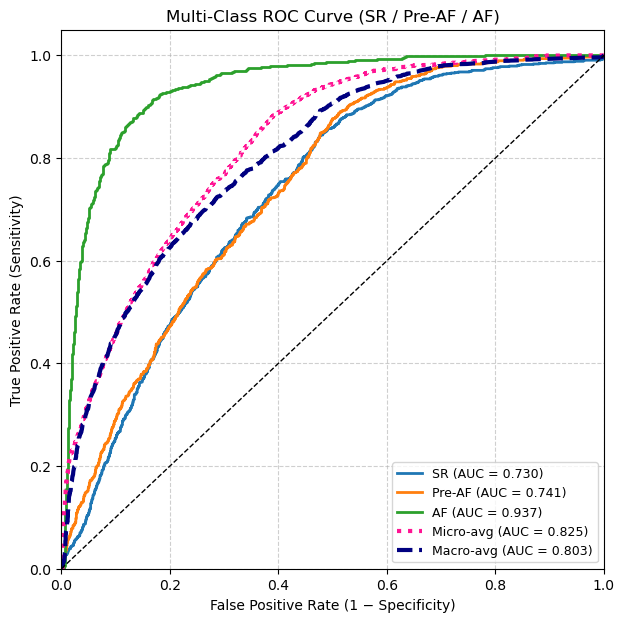

AUC[SR] = 0.7303
AUC[Pre-AF] = 0.7407
AUC[AF] = 0.9368
Micro-avg AUC = 0.8248
Macro-avg AUC = 0.8029


In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

num_classes = 3
y_all = [label for _, label in test_dataset]
y_true = np.array(y_all)  # labels: 0=SR, 1=Pre-AF, 2=AF

# --- Compute full probability matrix [N, 3] ---
probs_all = []

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)

probs_all = np.vstack(probs_all)   # shape [n_samples, 3]

# --- One-hot encode true labels ---
y_bin = label_binarize(y_true, classes=[0, 1, 2])

# --- Compute ROC curve & AUC for each class ---
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro- and macro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot ---
plt.figure(figsize=(7,7))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
class_names = ["SR", "Pre-AF", "AF"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", linewidth=3,
         label=f"Micro-avg (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], color="navy", linestyle="--", linewidth=3,
         label=f"Macro-avg (AUC = {roc_auc['macro']:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Multi-Class ROC Curve (SR / Pre-AF / AF)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Print numeric results ---
for i, name in enumerate(class_names):
    print(f"AUC[{name}] = {roc_auc[i]:.4f}")
print(f"Micro-avg AUC = {roc_auc['micro']:.4f}")
print(f"Macro-avg AUC = {roc_auc['macro']:.4f}")


### Find threshold using validation data

In [26]:
# --- Create validation loader ---
val_dataset = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)),
    torch.from_numpy(y_val.astype(np.int64))
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Compute danger probabilities (VAL SET) ---
prob_danger_val, true_danger_val = [], []

model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)  # shape [batch, 3]

        # P(SR) = probs[:,0], so danger = 1 - SR
        p_sr = probs[:, 0]
        p_danger = 1 - p_sr

        prob_danger_val.extend(p_danger.cpu().numpy())

        # Convert labels → binary danger: SR=0, (Pre-AF + AF)=1
        true_danger_val.extend((yb.numpy() != 0).astype(int))

prob_danger_val = np.array(prob_danger_val)
true_danger_val = np.array(true_danger_val)

print("🔍 Validation danger probability range:",
      prob_danger_val.min(), "-", prob_danger_val.max())
print("Validation danger label distribution:",
      np.bincount(true_danger_val))

# --- Sweep thresholds (VAL SET) ---
candidates = np.arange(0.0, 1.01, 0.01)
f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger_val >= t).astype(int)

    f1s.append(f1_score(true_danger_val, preds))
    accs.append(accuracy_score(true_danger_val, preds))
    precs.append(precision_score(true_danger_val, preds, zero_division=0))
    recs.append(recall_score(true_danger_val, preds))

max_f = max(f1s)
cut = 0.96 * max_f 

valid_idxs = [i for i, f in enumerate(f1s) if f >= cut]

# choose the largest threshold among valid candidates
best_idx = max(valid_idxs)
best_t = candidates[best_idx]

print(f"\n🎯 BEST THRESHOLD (96% F1 rule) = {best_t:.3f}")
print(f"Max F1 = {max_f:.4f}")
print(f"Chosen threshold F1 = {f1s[best_idx]:.4f}, Acc = {accs[best_idx]:.4f}, "
      f"Prec = {precs[best_idx]:.4f}, Rec = {recs[best_idx]:.4f}")

# Final threshold used in inference
window_threshold = best_t


🔍 Validation danger probability range: 0.106211305 - 0.9897769
Validation danger label distribution: [ 768 1529]

🎯 BEST THRESHOLD (96% F1 rule) = 0.540
Max F1 = 0.8014
Chosen threshold F1 = 0.7718, Acc = 0.6957, Prec = 0.7705, Rec = 0.7731


In [27]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.7993     0.6657    
0.01       0.7993     0.6657    
0.02       0.7993     0.6657    
0.03       0.7993     0.6657    
0.04       0.7993     0.6657    
0.05       0.7993     0.6657    
0.06       0.7993     0.6657    
0.07       0.7993     0.6657    
0.08       0.7993     0.6657    
0.09       0.7993     0.6657    
0.10       0.7993     0.6657    
0.11       0.7997     0.6665    
0.12       0.7997     0.6665    
0.13       0.7999     0.6670    
0.14       0.7999     0.6670    
0.15       0.7999     0.6670    
0.16       0.7999     0.6670    
0.17       0.7999     0.6670    
0.18       0.7999     0.6670    
0.19       0.7999     0.6670    
0.20       0.7999     0.6670    
0.21       0.7999     0.6670    
0.22       0.7998     0.6670    
0.23       0.7998     0.6670    
0.24       0.7995     0.6665    
0.25       0.7995     0.6665    
0.26       0.7997     0.6670    

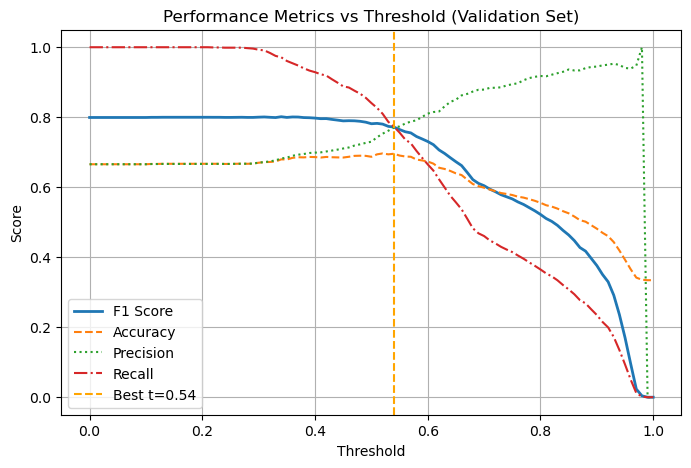

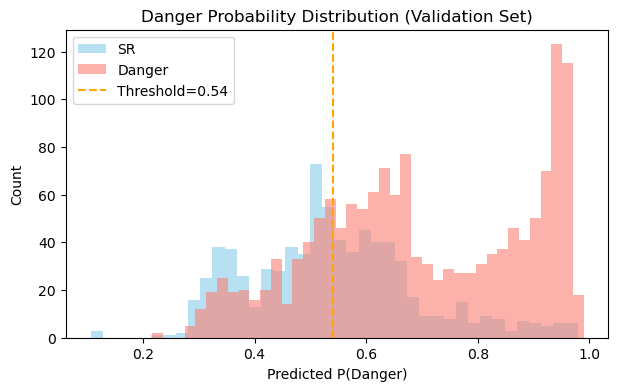

In [28]:

plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_danger_val[true_danger_val==0], bins=40, alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger_val[true_danger_val==1], bins=40, alpha=0.6, label="Danger", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Threshold={best_t:.2f}")
plt.xlabel("Predicted P(Danger)")
plt.ylabel("Count")
plt.title("Danger Probability Distribution (Validation Set)")
plt.legend()
plt.show()

### Find Predicted Time Horizon

In [29]:
print("\n================ TIME HORIZON (TEST SET) ================")
print("Using threshold:", window_threshold)

# --- Reload dataset ---
DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
window_duration_sec = 30

df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c.startswith("r_")]

# Clean dataset like before
X = df[feature_cols].values.astype(np.float32)
y_raw = df["label"].values
mask_good = np.isfinite(X).all(axis=1)
mask_good &= np.isfinite(y_raw) & (y_raw >= 0)
df_clean = df.loc[mask_good].reset_index(drop=True)

aligned_record_ids = df_clean["record_id"].values
y_all = df_clean["label"].values.astype(int)

print("Cleaned dataset:", df_clean.shape)

# --- Compute danger for TEST SET windows ---
prob_danger_test = []

test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test.astype(np.float32)),
                  torch.from_numpy(y_test.astype(np.int64))),
    batch_size=32, shuffle=False
)

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)
        prob_danger_test.extend((1 - probs[:, 0]).cpu().numpy())

prob_danger_test = np.array(prob_danger_test)

# --- Align lengths (if mismatch) ---
min_len = min(len(prob_danger_test), len(aligned_record_ids))
prob_danger_test = prob_danger_test[:min_len]
aligned_record_ids = aligned_record_ids[:min_len]
y_all = y_all[:min_len]

# --- Find AF onset per record ---
record_af_onset_indices = {}
unique_records = np.unique(aligned_record_ids)

for rid in unique_records:
    idxs = np.where(aligned_record_ids == rid)[0]
    labels = y_all[idxs]
    af_idx = np.where(labels == 2)[0]
    if len(af_idx) > 0:
        record_af_onset_indices[rid] = af_idx[0]

print("Found AF onset in", len(record_af_onset_indices), "records")

# --- Compute time horizon ---
time_horizons = []

for rid, onset_idx in record_af_onset_indices.items():
    idxs = np.where(aligned_record_ids == rid)[0]
    probs = prob_danger_test[idxs]

    first_alert = np.where(probs >= window_threshold)[0]

    if len(first_alert) > 0 and first_alert[0] < onset_idx:
        delta = onset_idx - first_alert[0]
        time_horizons.append(delta * window_duration_sec)

# --- SUMMARY ---
if time_horizons:
    print(f"\nMean predicted time horizon: {np.mean(time_horizons):.2f} s")
    print(f"Median predicted time horizon: {np.median(time_horizons):.2f} s")
    print(f"Detected {len(time_horizons)} AF records early.")
else:
    print("\n⚠️ No early detections found.")


================ TIME HORIZON (TEST SET) ================
Using threshold: 0.54
Cleaned dataset: (14357, 55)
Found AF onset in 19 records

Mean predicted time horizon: 2971.58 s
Median predicted time horizon: 3000.00 s
Detected 19 AF records early.
